# Troubleshooting and EDA

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.insert(0, '../../../../')
import mwc.stats
import mwc.viz
import mwc.bayes
import mwc.process
import imp
import scipy.special
import pymc3 as pm
%matplotlib inline
colors = mwc.viz.personal_style()

In [122]:
imp.reload(mwc.process)

<module 'mwc.process' from '../../../../mwc/process.py'>

## The problem

The estimated calibration factor for this set, taken using a shutter disabled LED, is remarkably off of what is predicted. In this notebook, I explore the data to see where these errors may be coming from.  

## Plotting the fluctuations

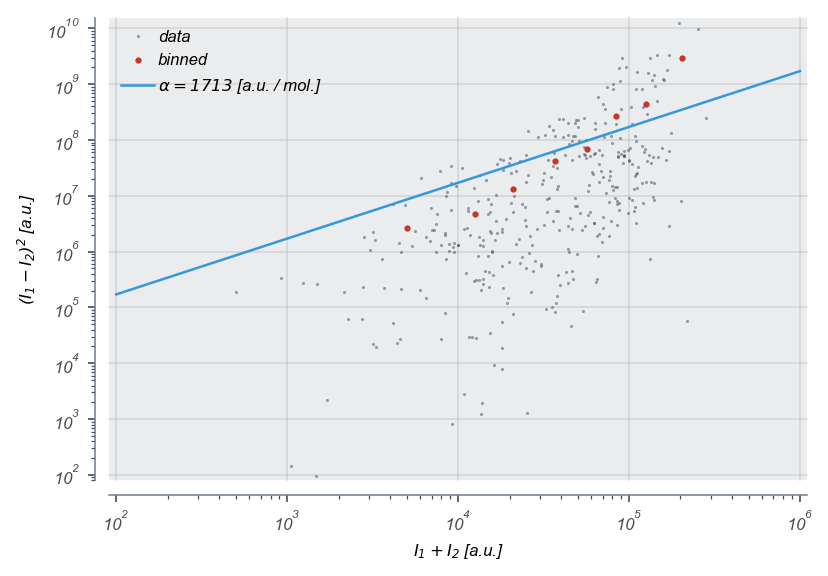

In [11]:
# Load the dataset.
data = pd.read_csv('output/20180222_tenjin_37C_glucose_O2_fluctuations.csv')

# Estimate the calibration factor. 
est, err = mwc.bayes.estimate_calibration_factor(data['I_1'], data['I_2'])

# Compute the theory.
summed_range = np.logspace(2, 6, 500)
theo = est * summed_range
# Bin by events
bin_size = 50
bin_dict = mwc.stats.bin_by_events(data, bin_size)


# Set up the figure. 
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_1 + I_2$ [a.u.]')
ax.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')

# Plot the data.
_ = ax.plot(data['summed'], data['fluct'], '.', ms=1, alpha=0.5, label='data')
_ = ax.plot(bin_dict['summed'], bin_dict['fluct'], '.', ms=4, label='binned')
_ = ax.plot(summed_range, theo, label=r'$\alpha = %0.0f$ [a.u. / mol.]' %(est))
_ = ax.legend()
mwc.viz.format_axes()

There is obviously some error. Let's take a look at the posterior. 


In [14]:
# Plot the log posterior.
alpha_range = np.linspace(100, 3000, 500)
log_post = np.zeros(len(alpha_range))
for i, a in enumerate(alpha_range):
    log_post[i] = mwc.bayes.deterministic_log_posterior(a, data['I_1'], data['I_2'],
                                                       neg=False)
    
# Renormalize the log posterior for plotting.
posterior = np.exp(log_post - scipy.special.logsumexp(log_post))

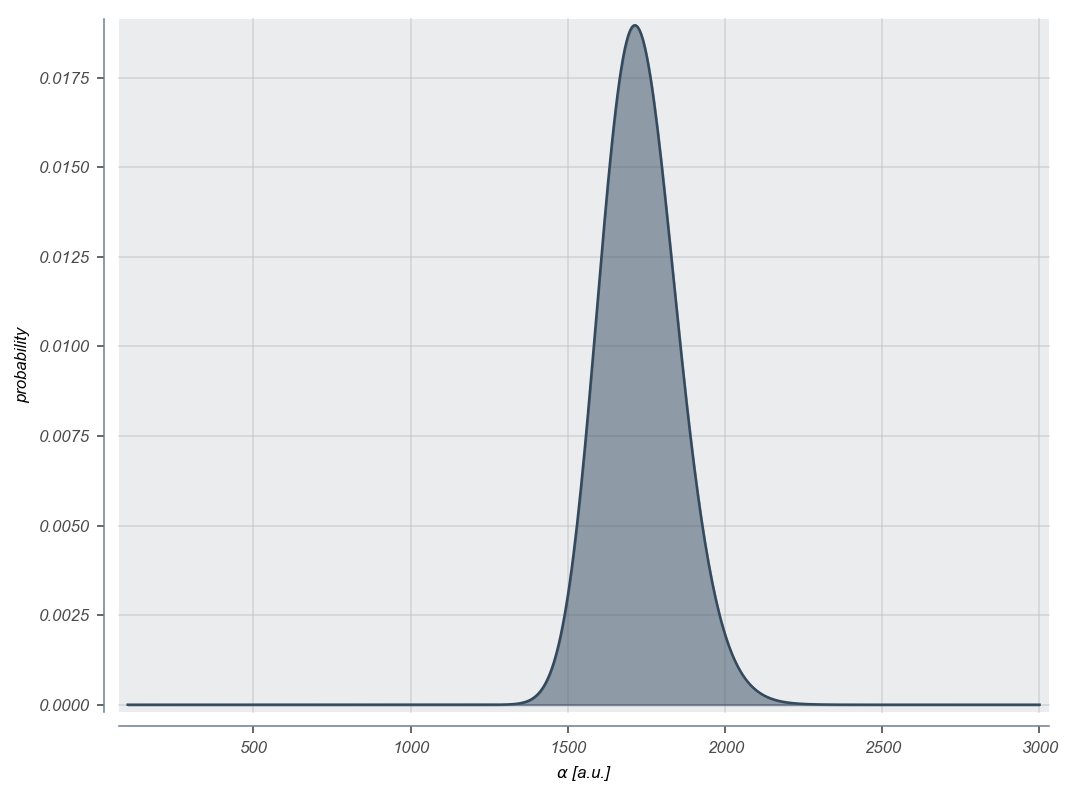

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$\alpha$ [a.u.]')
ax.set_ylabel('probability')
_ = ax.plot(alpha_range, posterior, color=colors[0])
_ = ax.fill_between(alpha_range, posterior, color=colors[0], alpha=0.5)
mwc.viz.format_axes()

The posterior looks okay, albeit a little bit skewed. Let's lookk at some other quality control checks

## Quality Control 

### Average partitioning

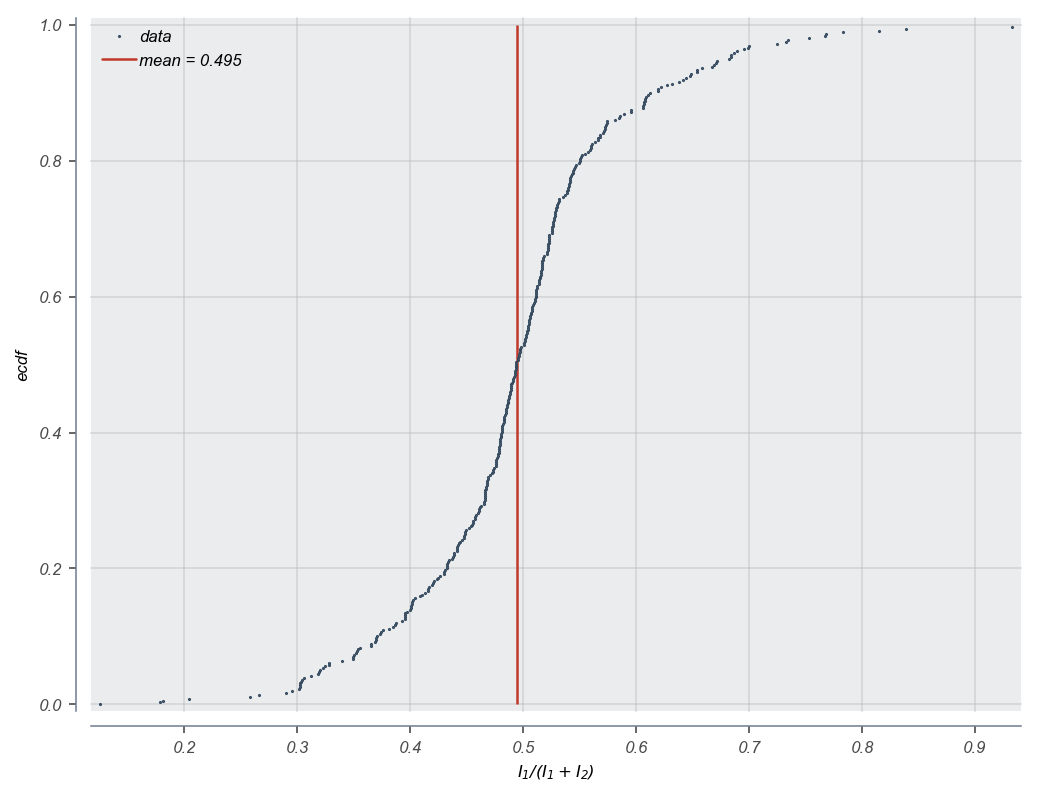

In [21]:
# FOr each cell division, compute the partitioning fraction. 
frac = data['I_1'] / data['summed']
mean_partitioning = np.mean(frac)
x, y = mwc.stats.ecdf(frac)
fig, ax = plt.subplots(1,1)
ax.set_xlabel(r'$I_1 / (I_1 + I_2)$')
ax.set_ylabel('ecdf')
_ = ax.plot(x, y, '.', ms=1, label='data')
_ = ax.vlines(mean_partitioning, 0, 1, label='mean = {0:0.3f}'.format(mean_partitioning), 
             color=colors[1])
_ = ax.legend()
mwc.viz.format_axes()

The mean appears to be right around 0.5, although there is some spread. My prediction is that at the extrema, the total intensity is weak.  

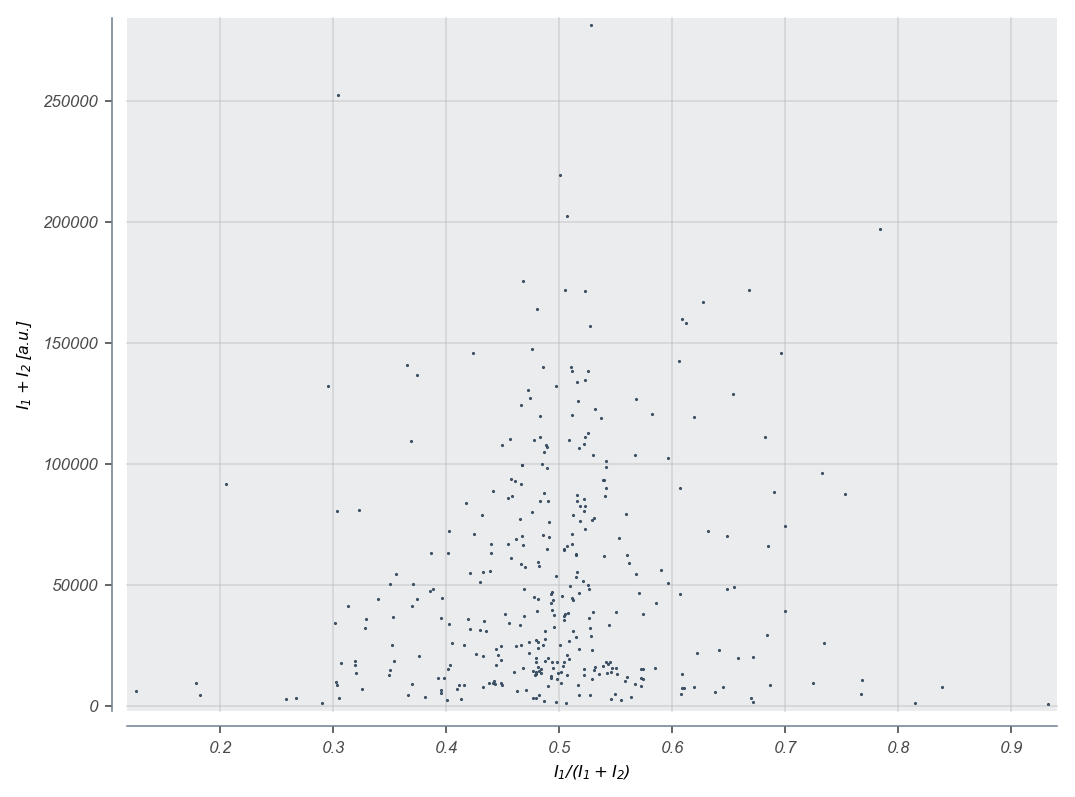

In [27]:
fig, ax = plt.subplots()
ax.set_ylabel('$I_1 + I_2$ [a.u.]')
ax.set_xlabel('$I_1 / (I_1 + I_2)$')
_ = ax.plot(frac, data['summed'], '.', ms=1)
mwc.viz.format_axes()

Okay, that also makes sense. The high and low variation correspond to the weaker expression levels. 

###  Spatiotemporal fluctuations

I can look at the mean background fluorescence to get a handle of how the intensity is changing from frame to frame. 

In [100]:
growth_df = pd.read_csv('output/20180222_tenjin_37C_glucose_O2_growth.csv')
snap_df = pd.read_csv('output/20180222_tenjin_37C_glucose_O2_snaps.csv')
# get the bg ignoring 0.
growth_bg_vals = np.sort(growth_df['fluor1_bg_death'].unique())[1:]
snap_bg_vals = snap_df['fluor1_bg_death'].unique()
bg_vals = np.concatenate((growth_bg_vals, snap_bg_vals))


In [101]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=500)
    sig = pm.HalfNormal('sigma', 100)
    like = pm.Normal('like', mu=mu, sd=sig, observed=bg_vals)
    trace = pm.sample(draws=5000, tune=5000)
    trace_df = mwc.stats.trace_to_dataframe(trace, model=model)
    stats = mwc.stats.compute_statistics(trace_df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, mu_interval__]
100%|██████████| 10000/10000 [00:05<00:00, 1667.40it/s]


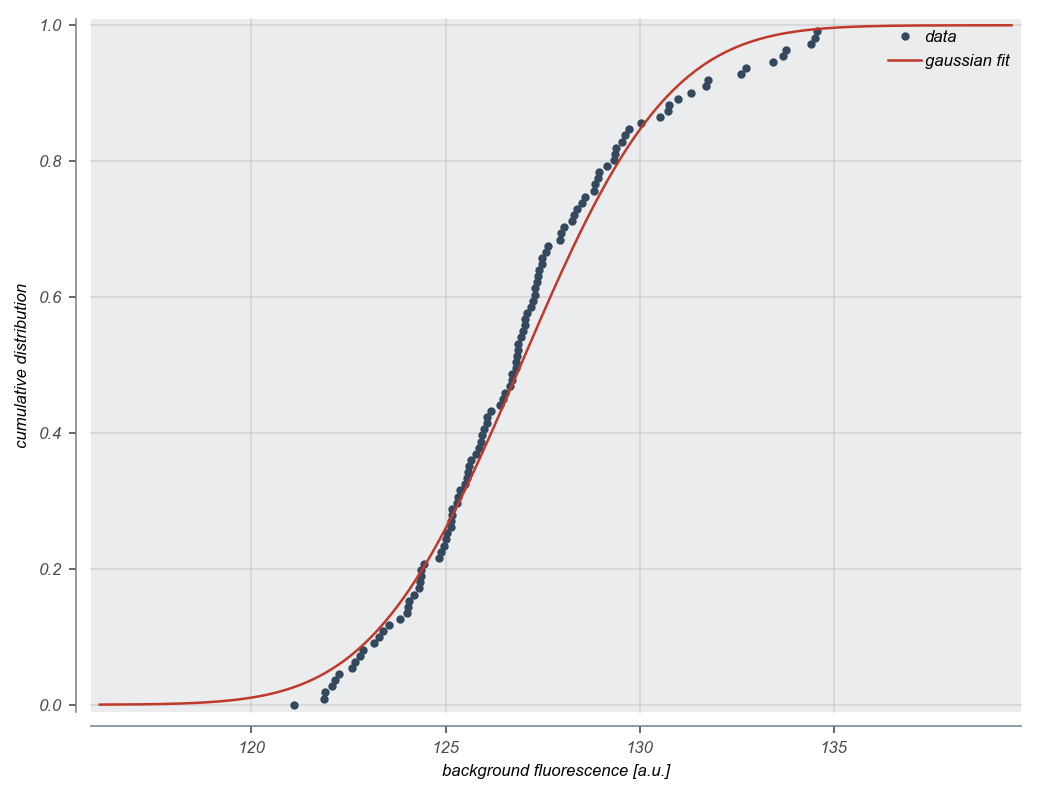

In [102]:
# Compute the gaussian fit. 
norm_fit = scipy.stats.norm(loc=stats[stats['parameter']=='mu']['mode'], scale=stats[stats['parameter']=='sigma']['mode'])

# Plot the data ecdf and the fit. 
bg_range = np.linspace(np.min(bg_vals) - 5, np.max(bg_vals) + 5, 500)
fit_cdf = norm_fit.cdf(bg_range)
x, y = mwc.stats.ecdf(bg_vals)

# Plot 
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('background fluorescence [a.u.]')
ax.set_ylabel('cumulative distribution')
_ = ax.plot(x, y, '.', label='data')
_ = ax.plot(bg_range, fit_cdf, label='gaussian fit')
_ = ax.legend()

mwc.viz.format_axes()

Ot looks approximately gaussian. 

What do the 'fluctuations' look like for every pairwise combination of background?

In [76]:
avg_area = np.mean(snap_df['area_death'])
bg_df = pd.DataFrame([], columns=['I_1', 'I_2', 'fluct', 'summed'])
for i in range(int(len(bg_vals) / 2)):
    for j in range(int(len(bg_vals) / 2), len(bg_vals)):
        if i != j:
            val_1 = bg_vals[i] * avg_area
            val_2 = bg_vals[j] * avg_area
            fluct = (val_1 - val_2)**2
            summed = (val_1 + val_2)
            bg_dict = {'I_1': val_1, 'I_2':val_2, 'fluct':fluct,
                      'summed':summed}
            bg_df = bg_df.append(bg_dict, ignore_index=True) 
    

Now plot and estimate the calibration factor 

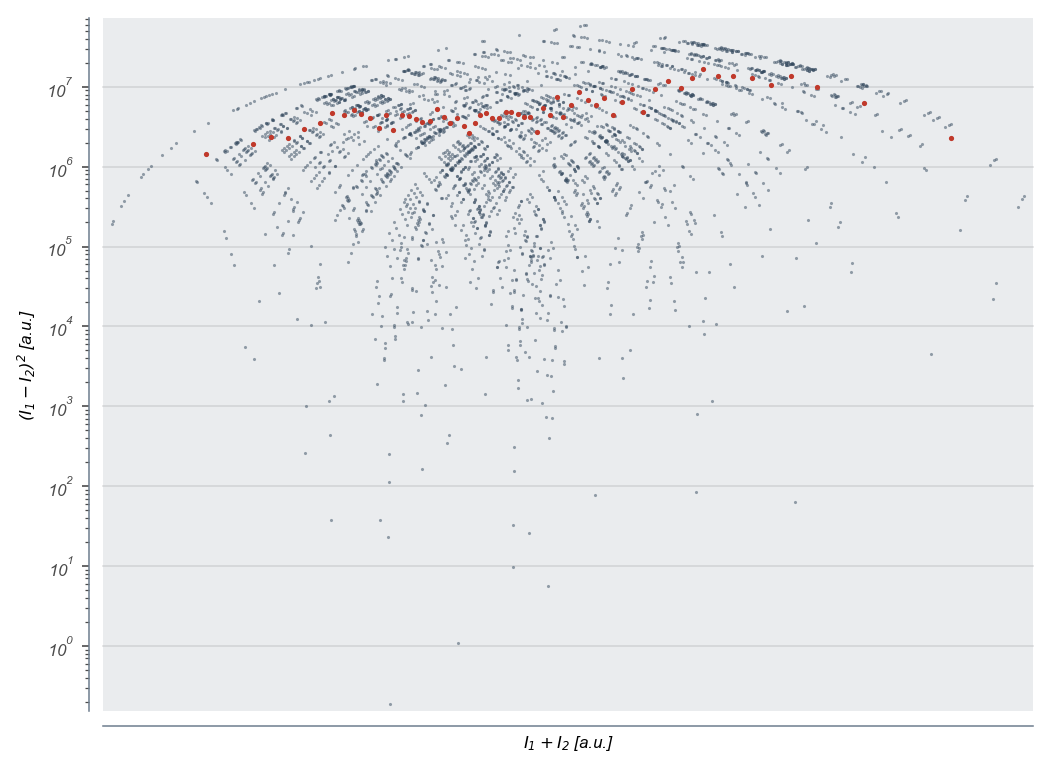

In [77]:
# Estimate the calibration factor. 
est, err = mwc.bayes.estimate_calibration_factor(bg_df['I_1'], bg_df['I_2'], 0)
bin_width = 50
binned_dict = mwc.stats.bin_by_events(bg_df, bin_width)

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('$I_1 + I_2$ [a.u.]')
ax.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')
ax.set_xscale('log')
ax.set_yscale('log')

_ = ax.plot(bg_df['summed'], bg_df['fluct'], '.', ms=1, alpha=0.5, label='data')
_ = ax.plot(binned_dict['summed'], binned_dict['fluct'], '.', ms=3, label='binned')

mwc.viz.format_axes()

In [78]:
est

2.6180339603380443

### Fluctuations in autofluorescence

In [79]:
auto_strain = snap_df[snap_df['strain']=='autofluorescence']

In [90]:
auto_df = pd.DataFrame([], columns=['I_1', 'I_2', 'fluct', 'summed'])
auto_vals = auto_strain['fluor1_mean_death']
for i in range(int(len(auto_vals) / 2)):
    for j in range(int(len(auto_vals) / 2), len(auto_vals)):
        if i != j:
            val_1 = auto_vals.values[i] * auto_strain.iloc[i]['area_death']
            val_2 = auto_vals.values[j] * auto_strain.iloc[j]['area_death']
            fluct = (val_1 - val_2)**2
            summed = (val_1 + val_2)
            auto_dict = {'I_1': val_1, 'I_2':val_2, 'fluct':fluct,
                      'summed':summed}
            auto_df = auto_df.append(auto_dict, ignore_index=True) 

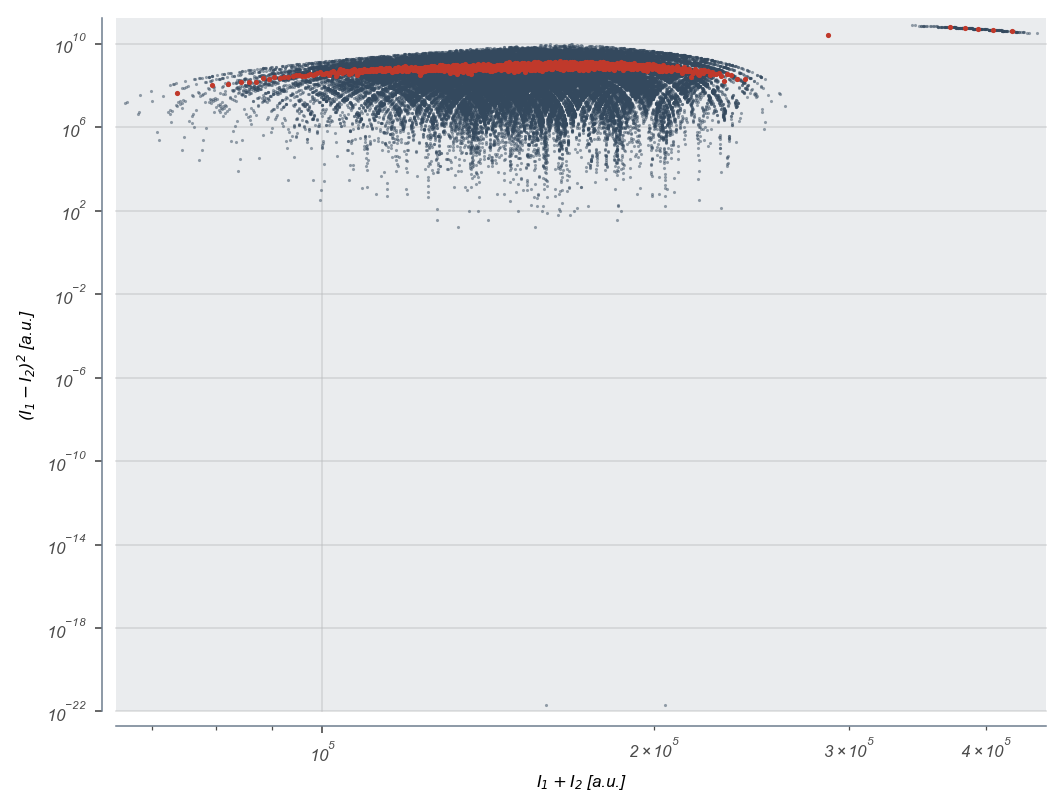

In [91]:
# Estimate the calibration factor. 
est, err = mwc.bayes.estimate_calibration_factor(auto_df['I_1'], auto_df['I_2'], 0)
bin_width = 50
binned_dict = mwc.stats.bin_by_events(auto_df, bin_width)

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('$I_1 + I_2$ [a.u.]')
ax.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')
ax.set_xscale('log')
ax.set_yscale('log')

_ = ax.plot(auto_df['summed'], auto_df['fluct'], '.', ms=1, alpha=0.5, label='data')
_ = ax.plot(binned_dict['summed'], binned_dict['fluct'], '.', ms=3, label='binned')

mwc.viz.format_axes()

In [95]:
est

2.6180339603380443

##  Improper corrections

Since the autofluorescence and the fluorescence background are basically identical, I'm not sure it makes sense to subtract each from the final dataset. 

(100, 150)

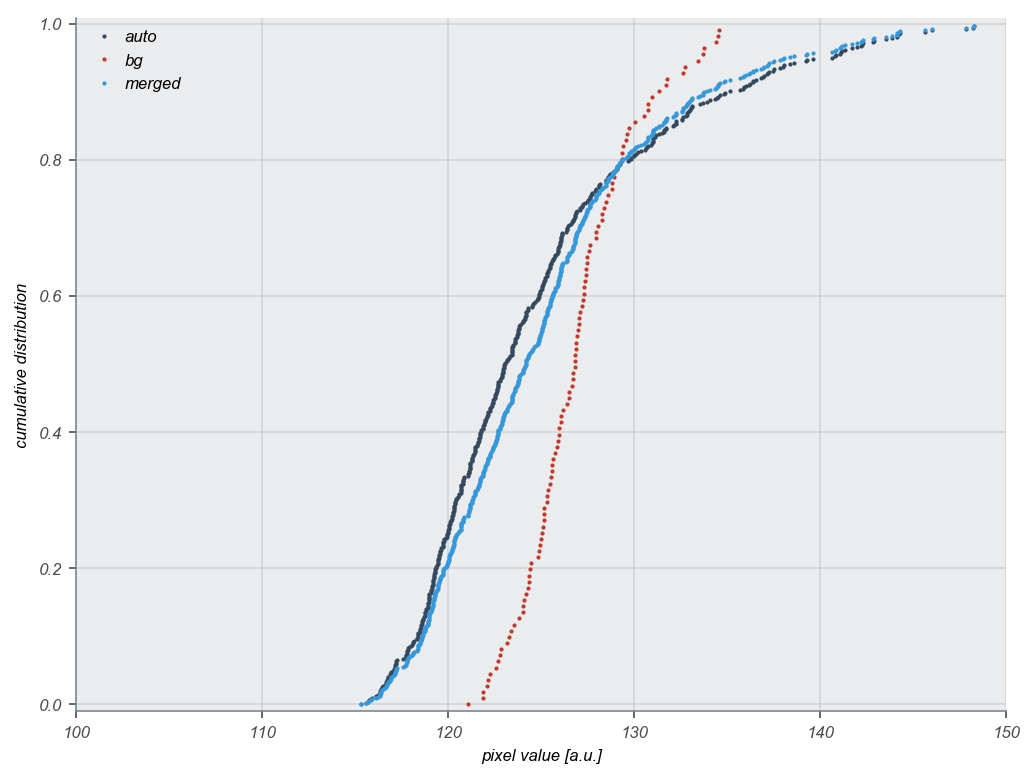

In [104]:
auto_x, auto_y = mwc.stats.ecdf(auto_vals)
bg_x, bg_y = mwc.stats.ecdf(bg_vals)
merged = np.concatenate((auto_vals, bg_vals))
merged_x, merged_y = mwc.stats.ecdf(merged)
fig, ax = plt.subplots(1,1)
ax.set_xlabel('pixel value [a.u.]')
ax.set_ylabel('cumulative distribution')
_ = ax.plot(auto_x, auto_y, '.', ms=2, label='auto')
_ = ax.plot(bg_x, bg_y, '.', ms=2, label='bg')
_ = ax.plot(merged_x, merged_y, '.', ms=2, label='merged')
_ = ax.legend()

#Ignore the spurious bright outlier. 
ax.set_xlim([100, 150])

Since these are about the same, let's subtract the median from the intensity measurements and compute the fluctuations. 


In [124]:
avg_sub = np.median(merged)
fluct = mwc.process.compute_fluctuations(growth_df, avg_sub)

Grouping by position and mother ID....


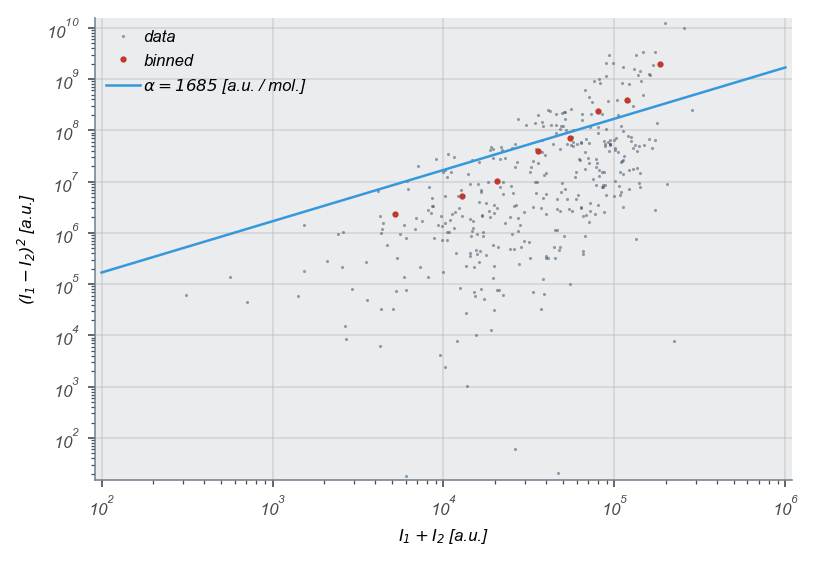

In [123]:
# Estimate the calibration factor. 
est, err = mwc.bayes.estimate_calibration_factor(fluct['I_1'], fluct['I_2'])

# Compute the theory.
summed_range = np.logspace(2, 6, 500)
theo = est * summed_range
# Bin by events
bin_size = 50
bin_dict = mwc.stats.bin_by_events(fluct, bin_size)


# Set up the figure. 
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_1 + I_2$ [a.u.]')
ax.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')

# Plot the data.
_ = ax.plot(fluct['summed'], fluct['fluct'], '.', ms=1, alpha=0.5, label='data')
_ = ax.plot(bin_dict['summed'], bin_dict['fluct'], '.', ms=4, label='binned')
_ = ax.plot(summed_range, theo, label=r'$\alpha = %0.0f$ [a.u. / mol.]' %(est))
_ = ax.legend()

That made some degree of progress, but not a lot. What if I subtract by both?


Grouping by position and mother ID....


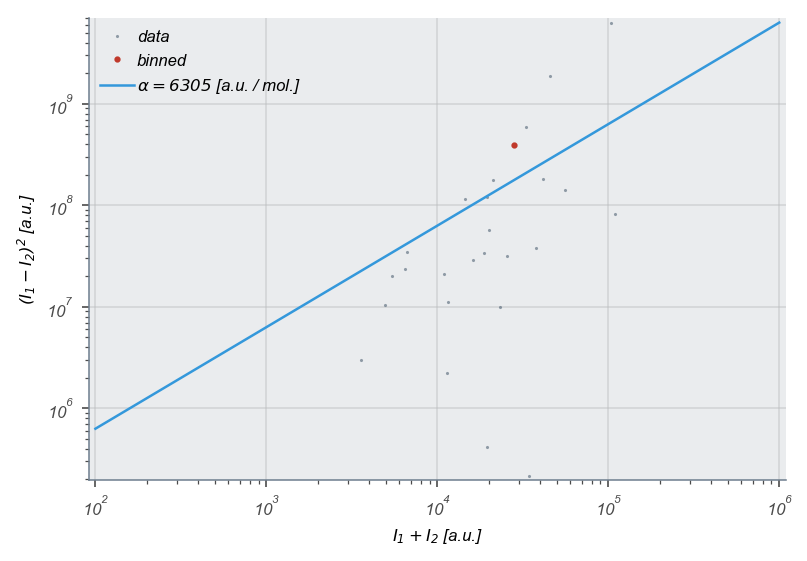

In [125]:
avg_sub = np.median(bg_vals) + np.median(auto_vals)
fluct = mwc.process.compute_fluctuations(growth_df, avg_sub)
# Estimate the calibration factor. 
est, err = mwc.bayes.estimate_calibration_factor(fluct['I_1'], fluct['I_2'])

# Compute the theory.
summed_range = np.logspace(2, 6, 500)
theo = est * summed_range
# Bin by events
bin_size = 50
bin_dict = mwc.stats.bin_by_events(fluct, bin_size)


# Set up the figure. 
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_1 + I_2$ [a.u.]')
ax.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')

# Plot the data.
_ = ax.plot(fluct['summed'], fluct['fluct'], '.', ms=1, alpha=0.5, label='data')
_ = ax.plot(bin_dict['summed'], bin_dict['fluct'], '.', ms=4, label='binned')
_ = ax.plot(summed_range, theo, label=r'$\alpha = %0.0f$ [a.u. / mol.]' %(est))
_ = ax.legend()

As expected, that is bad news. I should one subtract one or the other, so I opt for subtracting the mean autofluorescence.  

###  Normalizing for background fluorescence 